# 1. 글자 단위 RNN 언어 모델(Char RNNLM)

In [6]:
import numpy as np
import urllib.request

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [7]:
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
urllib.request.urlretrieve("http://www.gutenberg.org/files/11/11-0.txt", filename="11-0.txt")

('11-0.txt', <http.client.HTTPMessage at 0x1d47a808310>)

In [9]:
f = open('11-0.txt', 'rb')

In [10]:
sentences = []

for sentence in f:                    # 데이터를 한 줄씩 읽는다.
    sentence = sentence.strip()       # strip()을 통해 \r, \n을 제거한다.
    sentence = sentence.lower()       # 소문자화.
    sentence = sentence.decode('ascii', 'ignore') 
                                      # \xe2\x80\x99 등과 같은 바이트 열 제거
    if len(sentence) > 0:
        sentences.append(sentence)
        
f.close()

In [11]:
sentences[:14]

['the project gutenberg ebook of alices adventures in wonderland, by lewis carroll',
 'this ebook is for the use of anyone anywhere in the united states and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever. you may copy it, give it away or re-use it under the terms',
 'of the project gutenberg license included with this ebook or online at',
 'www.gutenberg.org. if you are not located in the united states, you',
 'will have to check the laws of the country where you are located before',
 'using this ebook.',
 'title: alices adventures in wonderland',
 'author: lewis carroll',
 'release date: january, 1991 [ebook #11]',
 '[most recently updated: october 12, 2020]',
 'language: english',
 'character set encoding: utf-8']

In [12]:
total_data = ' '.join(sentences)
print('Length of string or total number of letters: %d' % len(total_data))

Length of string or total number of letters: 159484


### small data size : 10,000
### 실습시 small, large size 

In [13]:
total_data = total_data[:10000]

In [14]:
print(total_data[:100])

the project gutenberg ebook of alices adventures in wonderland, by lewis carroll this ebook is for t


In [15]:
print(total_data[:500])

the project gutenberg ebook of alices adventures in wonderland, by lewis carroll this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever. you may copy it, give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org. if you are not located in the united states, you will have to check the laws of the country where you are located b


In [16]:
char_vocab = sorted(list(set(total_data)))

vocab_size = len(char_vocab)

print ('The size of the letter set : {}'.format(vocab_size))

The size of the letter set : 47


In [17]:
#글자에 고유한 정수 인덱스 부여
    
char_to_index = dict((char, index) for index, char in enumerate(char_vocab)) 
 
print(char_to_index)

{' ': 0, '!': 1, '#': 2, '(': 3, ')': 4, '*': 5, ',': 6, '-': 7, '.': 8, '0': 9, '1': 10, '2': 11, '3': 12, '8': 13, '9': 14, ':': 15, ';': 16, '?': 17, '[': 18, ']': 19, '_': 20, 'a': 21, 'b': 22, 'c': 23, 'd': 24, 'e': 25, 'f': 26, 'g': 27, 'h': 28, 'i': 29, 'j': 30, 'k': 31, 'l': 32, 'm': 33, 'n': 34, 'o': 35, 'p': 36, 'q': 37, 'r': 38, 's': 39, 't': 40, 'u': 41, 'v': 42, 'w': 43, 'x': 44, 'y': 45, 'z': 46}


In [18]:
index_to_char={}

for key, value in char_to_index.items():
    index_to_char[value] = key

In [19]:
# 문장의 길이를 60으로 한다.
seq_length = 60 

# 문자열을 60등분한다. 그러면 즉, 총 샘플의 개수
n_samples = int(np.floor((len(total_data) - 1) / seq_length)) 

print ('The number of sentence samples : {}'.format(n_samples))

The number of sentence samples : 166


In [20]:
train_X = []
train_y = []

for i in range(n_samples):
    # 0:60 -> 60:120 -> 120:180로 loop를 돌면서 문장 샘플을 1개씩 픽한다.
    X_sample = total_data[i * seq_length: (i + 1) * seq_length]

    # 정수 인코딩
    X_encoded = [char_to_index[c] for c in X_sample]
    train_X.append(X_encoded)

    # 오른쪽으로 1칸 쉬프트
    y_sample = total_data[i * seq_length + 1: (i + 1) * seq_length + 1]
    y_encoded = [char_to_index[c] for c in y_sample]
    train_y.append(y_encoded)

In [21]:
print(train_X[0])

[40, 28, 25, 0, 36, 38, 35, 30, 25, 23, 40, 0, 27, 41, 40, 25, 34, 22, 25, 38, 27, 0, 25, 22, 35, 35, 31, 0, 35, 26, 0, 21, 32, 29, 23, 25, 39, 0, 21, 24, 42, 25, 34, 40, 41, 38, 25, 39, 0, 29, 34, 0, 43, 35, 34, 24, 25, 38, 32, 21]


In [22]:
print(train_y[0])

[28, 25, 0, 36, 38, 35, 30, 25, 23, 40, 0, 27, 41, 40, 25, 34, 22, 25, 38, 27, 0, 25, 22, 35, 35, 31, 0, 35, 26, 0, 21, 32, 29, 23, 25, 39, 0, 21, 24, 42, 25, 34, 40, 41, 38, 25, 39, 0, 29, 34, 0, 43, 35, 34, 24, 25, 38, 32, 21, 34]


In [23]:
print(train_X[1])

[34, 24, 6, 0, 22, 45, 0, 32, 25, 43, 29, 39, 0, 23, 21, 38, 38, 35, 32, 32, 0, 40, 28, 29, 39, 0, 25, 22, 35, 35, 31, 0, 29, 39, 0, 26, 35, 38, 0, 40, 28, 25, 0, 41, 39, 25, 0, 35, 26, 0, 21, 34, 45, 35, 34, 25, 0, 21, 34, 45]


In [24]:
print(train_y[1])

[24, 6, 0, 22, 45, 0, 32, 25, 43, 29, 39, 0, 23, 21, 38, 38, 35, 32, 32, 0, 40, 28, 29, 39, 0, 25, 22, 35, 35, 31, 0, 29, 39, 0, 26, 35, 38, 0, 40, 28, 25, 0, 41, 39, 25, 0, 35, 26, 0, 21, 34, 45, 35, 34, 25, 0, 21, 34, 45, 43]


In [25]:
train_X = to_categorical(train_X)
train_y = to_categorical(train_y)

In [26]:
print('train_X의 크기(shape) : {}'.format(train_X.shape)) # 원-핫 인코딩
print('train_y의 크기(shape) : {}'.format(train_y.shape)) # 원-핫 인코딩

train_X의 크기(shape) : (166, 60, 47)
train_y의 크기(shape) : (166, 60, 47)


## 02. 모델 설계하기

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

In [28]:
hidden_units = 32

In [29]:
model = Sequential()
model.add(LSTM(hidden_units, input_shape=(None, train_X.shape[2]), return_sequences=True))
model.add(LSTM(hidden_units, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          10240     
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          8320      
                                                                 
 time_distributed (TimeDistr  (None, None, 47)         1551      
 ibuted)                                                         
                                                                 
Total params: 20,111
Trainable params: 20,111
Non-trainable params: 0
_________________________________________________________________


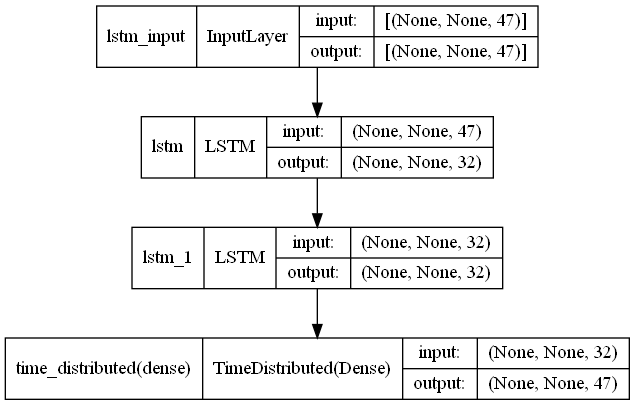

In [30]:
dot_img_file = './log_model2.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [31]:
#!pip install pydot

In [32]:
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [33]:
import time 
start = time.perf_counter()
history = model.fit(train_X, train_y, epochs=50, verbose=2)
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/50
6/6 - 4s - loss: 0.1028 - accuracy: 0.0829 - 4s/epoch - 701ms/step
Epoch 2/50
6/6 - 0s - loss: 0.1021 - accuracy: 0.1974 - 318ms/epoch - 53ms/step
Epoch 3/50
6/6 - 0s - loss: 0.1007 - accuracy: 0.1991 - 330ms/epoch - 55ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0975 - accuracy: 0.1992 - 301ms/epoch - 50ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0933 - accuracy: 0.1992 - 316ms/epoch - 53ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0902 - accuracy: 0.1992 - 320ms/epoch - 53ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0880 - accuracy: 0.1992 - 311ms/epoch - 52ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0865 - accuracy: 0.1992 - 308ms/epoch - 51ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0856 - accuracy: 0.1992 - 331ms/epoch - 55ms/step
Epoch 10/50
6/6 - 0s - loss: 0.0850 - accuracy: 0.1992 - 310ms/epoch - 52ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0846 - accuracy: 0.1992 - 318ms/epoch - 53ms/step
Epoch 12/50
6/6 - 0s - loss: 0.0843 - accuracy: 0.1992 - 320ms/epoch - 53ms/step
Epoch 13/50
6/6 - 0s - loss: 0.0841 - a

In [34]:
import matplotlib.pyplot as plt

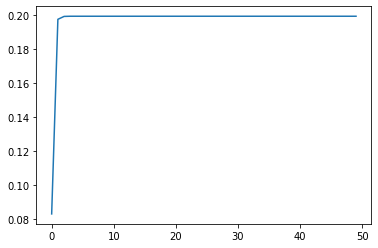

In [35]:
plt.plot(history.history['accuracy'])

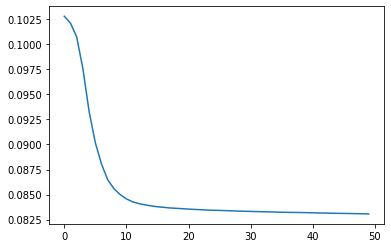

In [36]:
plt.plot(history.history['loss'])

In [37]:
def sentence_generation(model, length):
    # 글자에 대한 랜덤 인덱스 생성
    ix = [np.random.randint(vocab_size)]

    # 랜덤 익덱스로부터 글자 생성
    y_char = [index_to_char[ix[-1]]]
    print(ix[-1],'th character',y_char[-1],' predict!')

    # (1, length, 55) 크기의 X 생성. 즉, LSTM의 입력 시퀀스 생성
    X = np.zeros((1, length, vocab_size))

    for i in range(length):
        # X[0][i][예측한 글자의 인덱스] = 1, 즉, 예측 글자를 다음 입력 시퀀스에 추가
        X[0][i][ix[-1]] = 1
        print(index_to_char[ix[-1]], end="")
        ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
        y_char.append(index_to_char[ix[-1]])
    return ('').join(y_char)

In [38]:
result = sentence_generation(model, 200)
print(result)

45 th character y  predict!
y                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   y                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       